In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import classification_report,mean_absolute_error,ConfusionMatrixDisplay  
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('fraud_oracle.csv')

In [3]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [4]:
class FraudDetection:
    def __init__(self, data_path):
        self.df = pd.read_csv(data_path)
        
    def load_data(self):
        self.df = pd.read_csv(data_path)
    def print_data_summary(self):
        print('The data contains', len(self.df), 'observations.')
        print(" "*50)
        print(self.df.head())
        print(" "*50)
        print(self.df.dtypes)
        print(" "*50)
    def print_unique_values(self, column_name):
        unique_values = self.df[column_name].unique()
        print(column_name, unique_values)
        print(" "*50)
    def uniquecheck(self):
        self.print_data_summary()
        
        columns_to_analyze = [
            'Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
            'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus', 'Age', 'Fault',
            'PolicyType', 'VehicleCategory', 'VehiclePrice', 'FraudFound_P', 'PolicyNumber',
            'RepNumber', 'Deductible', 'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim',
            'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled',
            'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim',
            'NumberOfCars', 'Year', 'BasePolicy'
        ]
        
        for column in columns_to_analyze:
            self.print_unique_values(column)

    def explore_data(self):
        print("Head of the DataFrame:")
        print(self.df.head())
        
        print("\nDataFrame shape:", self.df.shape)
        
        print("\nValue counts of NumberOfSuppliments:")
        print(self.df.NumberOfSuppliments.value_counts())
        
        plt.scatter(self.df['Age'], self.df['Year'])
        
        print("\nColumns in the DataFrame:")
        print(self.df.columns)
        
        print("\nDataFrame info:")
        print(self.df.info())
        
        print("\nSummary statistics:")
        print(self.df.describe().T)
        
        self.df.set_index('PolicyNumber')
        
        plt.figure(figsize=(15, 10))
        self.df.hist()
        plt.subplots_adjust(hspace=0.5)
        
    def fraud_percentage(self):
        fraud_count = self.df['FraudFound_P'].sum()
        total_count = len(self.df['FraudFound_P'])
        non_fraud_count = total_count - fraud_count
        
        print("The number of non-fraudster claims is:", non_fraud_count)
        print("The percentage of non-fraudster claims is: {}%".format(round((non_fraud_count / total_count) * 100, 2)))
        print("-" * 40)
        print("The number of fraudster claims is:", fraud_count)
        print("The percentage of fraudster claims is: {}%".format(round((fraud_count / total_count) * 100, 2)))
        print("-" * 40)
        print("The number of total claims is:", total_count)
        
    def month_analysis(self):
        item_counts = self.df['Month'].value_counts(normalize=True)
        print("Percentage distribution among months:")
        print(round((item_counts * 100), 2))
        
        df_month = self.df.groupby(['Month']).size().reset_index().rename(columns={0: 'Num_accidents'})
        
        self.df['MonthName'] = pd.Categorical(self.df['Month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        
        sns.countplot(data=self.df['Month'], x=self.df['MonthName'])
        plt.xticks(rotation=55, horizontalalignment='right')
        plt.ylabel('Num. of claims')
        plt.xlabel('Month')
        plt.show()
        
        month_fraud_counts = self.df[['Month', 'FraudFound_P']].groupby(['Month', 'FraudFound_P']).size().reset_index()
        # Additional visualization and analysis can be done here
       
    def car_maker_analysis(self):
        Make = self.df['Make'].value_counts()
        plt.figure(figsize=(18, 3))
        sns.countplot(x="Make", hue='FraudFound_P', data=self.df)
        labels = ['No Fraud', 'Fraud']
        plt.legend(labels)
        plt.title('Fraud distribution by Make')
        plt.xlabel('Make')
        plt.ylabel('N. of claims')
        plt.show()
        
        
    def preprocess_data(self):
        month_mapping = {'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3, 'May': 4, 'Jun': 5, 'Jul': 6, 'Aug': 7, 'Sep': 8, 'Oct': 9, 'Nov': 10, 'Dec': 11}
        day_of_week_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
        make_mapping = {'Lexus': 0, 'Ferrari': 1, 'Mecedes': 2, 'Porche': 3, 'Jaguar': 4, 'BMW': 5, 'Nisson': 6, 'Saturn': 7, 'Mercury': 8, 'Dodge': 9, 'Saab': 10, 'VW': 11, 'Ford': 12, 'Accura': 13, 'Chevrolet': 14, 'Mazda': 15, 'Honda': 16, 'Toyota': 17, 'Pontiac': 18}
        accident_area_mapping = {'Rural': 0, 'Urban': 1}
        day_of_week_claimed_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
        month_claimed_mapping = {'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3, 'May': 4, 'Jun': 5, 'Jul': 6, 'Aug': 7, 'Sep': 8, 'Oct': 9, 'Nov': 10, 'Dec': 11}
        sex_mapping = {'Female': 0, 'Male': 1}
        marital_status_mapping = {'Widow': 0, 'Divorced': 1, 'Single': 2, 'Married': 3}
        fault_mapping = {'Third Party': 0, 'Policy Holder': 1}
        policy_type_mapping = {'Sport - Liability': 0, 'Sport - All Perils': 1, 'Utility - Liability': 2, 'Utility - Collision': 3, 'Utility - All Perils': 4, 'Sport - Collision': 5, 'Sedan - All Perils': 6, 'Sedan - Liability': 7, 'Sedan - Collision': 8}
        vehicle_category_mapping = {'Utility': 0, 'Sport': 1, 'Sedan': 2}
        vehicle_price_mapping = {'less than 20000': 0, '20000 to 29000': 1, '30000 to 39000': 2, '40000 to 59000': 3, '60000 to 69000': 4, 'more than 69000': 5}
        days_policy_accident_mapping = {'none': 0, '1 to 7': 1, '8 to 15': 2, '15 to 30': 3, 'more than 30': 4}
        days_policy_claim_mapping = {'8 to 15': 0, '15 to 30': 1, 'more than 30': 2}
        past_number_of_claims_mapping = {'none': 0, '1': 1, '2 to 4': 2, 'more than 4': 3}
        age_of_vehicle_mapping = {'new': 0, '2 years': 1, '3 years': 2, '4 years': 3, '5 years': 4, '6 years': 5, '7 years': 6, 'more than 7': 7}
        age_of_policy_holder_mapping = {'16 to 17':0,'18 to 20': 1, '21 to 25': 2, '26 to 30': 3, '31 to 35': 4, '36 to 40': 5, '41 to 50': 6, '51 to 65': 7, 'over 65': 8}
        police_report_filed_mapping = {'Yes': 0, 'No': 1}
        witness_present_mapping = {'Yes': 0, 'No': 1}
        agent_type_mapping = {'Internal': 0, 'External': 1}
        num_suppliments_mapping = {'none': 0, '1 to 2': 1, '3 to 5': 2, 'more than 5': 3}
        address_change_claim_mapping = {'no change': 0, 'under 6 months': 1, '1 year': 2, '2 to 3 years': 3, '4 to 8 years': 4}
        num_cars_mapping = {'1 vehicle': 0, '2 vehicles': 1, '3 to 4': 2, '5 to 8': 3, 'more than 8': 4}
        base_policy_mapping = {'All Perils': 0, 'Liability': 1, 'Collision': 2}
        self.df.MonthClaimed.replace('0', np.nan, inplace=True)
        self.df.DayOfWeekClaimed.replace('0', np.nan, inplace=True)
        
        
        self.df['Month'] = self.df['Month'].replace(month_mapping)
        self.df['DayOfWeek'] = self.df['DayOfWeek'].replace(day_of_week_mapping)
        self.df['Make'] = self.df['Make'].replace(make_mapping)
        self.df['AccidentArea'] = self.df['AccidentArea'].replace(accident_area_mapping)
        self.df['DayOfWeekClaimed'] = self.df['DayOfWeekClaimed'].replace(day_of_week_claimed_mapping)
        self.df['MonthClaimed'] = self.df['MonthClaimed'].replace(month_claimed_mapping)
        self.df['Sex'] = self.df['Sex'].replace(sex_mapping)
        self.df['MaritalStatus'] = self.df['MaritalStatus'].replace(marital_status_mapping)
        self.df['Fault'] = self.df['Fault'].replace(fault_mapping)
        self.df['PolicyType'] = self.df['PolicyType'].replace(policy_type_mapping)
        self.df['VehicleCategory'] = self.df['VehicleCategory'].replace(vehicle_category_mapping)
        self.df['VehiclePrice'] = self.df['VehiclePrice'].replace(vehicle_price_mapping)
        self.df['Days_Policy_Accident'] = self.df['Days_Policy_Accident'].replace(days_policy_accident_mapping)
        self.df['Days_Policy_Claim'] = self.df['Days_Policy_Claim'].replace(days_policy_claim_mapping)
        self.df['PastNumberOfClaims'] = self.df['PastNumberOfClaims'].replace(past_number_of_claims_mapping)
        self.df['AgeOfVehicle'] = self.df['AgeOfVehicle'].replace(age_of_vehicle_mapping)
        self.df['AgeOfPolicyHolder'] = self.df['AgeOfPolicyHolder'].replace(age_of_policy_holder_mapping)
        self.df['PoliceReportFiled'] = self.df['PoliceReportFiled'].replace(police_report_filed_mapping)
        self.df['WitnessPresent'] = self.df['WitnessPresent'].replace(witness_present_mapping)
        self.df['AgentType'] = self.df['AgentType'].replace(agent_type_mapping)
        self.df['NumberOfSuppliments'] = self.df['NumberOfSuppliments'].replace(num_suppliments_mapping)
        self.df['AddressChange_Claim'] = self.df['AddressChange_Claim'].replace(address_change_claim_mapping)
        self.df['NumberOfCars'] = self.df['NumberOfCars'].replace(num_cars_mapping)
        self.df['BasePolicy'] = self.df['BasePolicy'].replace(base_policy_mapping)
        self.df = self.df[self.df['Age'] >= 15]

        print("Data preprocessing completed.")
        self.df.drop(columns=['PolicyNumber', "MonthName"], inplace=True)


In [5]:
data_path = 'fraud_oracle.csv'
fraud_detection = FraudDetection(data_path)

In [6]:
fraud_detection.uniquecheck()

The data contains 15420 observations.
                                                  
  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years  

Head of the DataFrame:
  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years   

  AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType 

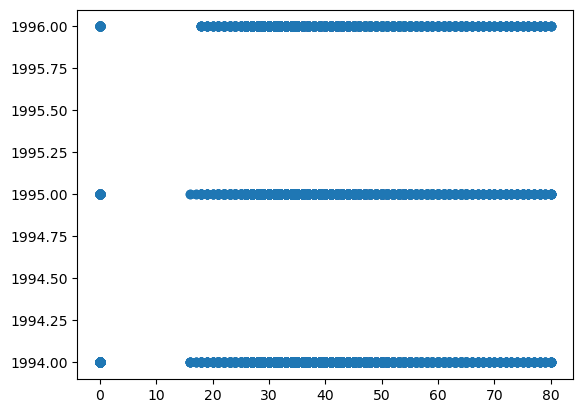

<Figure size 1500x1000 with 0 Axes>

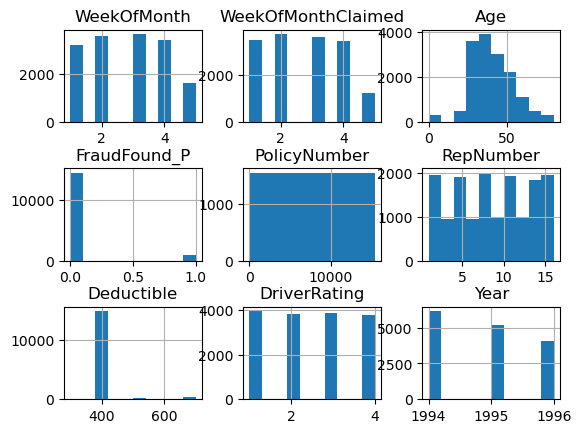

In [7]:
fraud_detection.explore_data()


In [8]:

fraud_detection.fraud_percentage()


The number of non-fraudster claims is: 14497
The percentage of non-fraudster claims is: 94.01%
----------------------------------------
The number of fraudster claims is: 923
The percentage of fraudster claims is: 5.99%
----------------------------------------
The number of total claims is: 15420


Percentage distribution among months:
Jan    9.15
May    8.87
Mar    8.82
Jun    8.57
Oct    8.46
Dec    8.33
Apr    8.30
Feb    8.21
Jul    8.15
Sep    8.04
Nov    7.79
Aug    7.31
Name: Month, dtype: float64


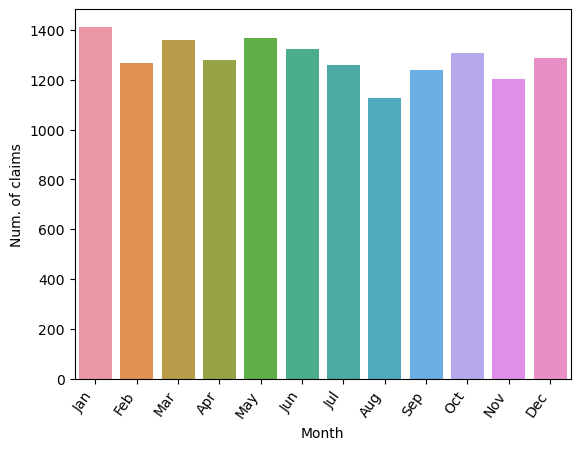

In [9]:
fraud_detection.month_analysis()


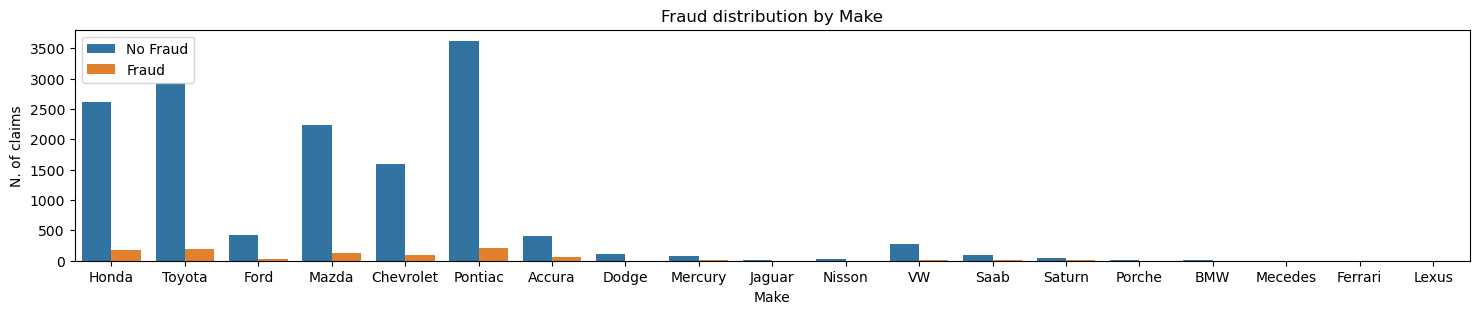

In [10]:
fraud_detection.car_maker_analysis()


In [11]:
fraud_detection.preprocess_data()

Data preprocessing completed.


In [12]:
fraud_detection.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15100 entries, 0 to 15419
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 15100 non-null  int64  
 1   WeekOfMonth           15100 non-null  int64  
 2   DayOfWeek             15100 non-null  int64  
 3   Make                  15100 non-null  int64  
 4   AccidentArea          15100 non-null  int64  
 5   DayOfWeekClaimed      15100 non-null  float64
 6   MonthClaimed          15100 non-null  float64
 7   WeekOfMonthClaimed    15100 non-null  int64  
 8   Sex                   15100 non-null  int64  
 9   MaritalStatus         15100 non-null  int64  
 10  Age                   15100 non-null  int64  
 11  Fault                 15100 non-null  int64  
 12  PolicyType            15100 non-null  int64  
 13  VehicleCategory       15100 non-null  int64  
 14  VehiclePrice          15100 non-null  int64  
 15  FraudFound_P       

In [13]:
fraud_detection.df['Days_Policy_Claim'].value_counts()

2    15023
1       56
0       21
Name: Days_Policy_Claim, dtype: int64

In [14]:
fraud_detection.df['Days_Policy_Claim']

0        2
1        2
2        2
3        2
4        2
        ..
15415    2
15416    2
15417    2
15418    2
15419    2
Name: Days_Policy_Claim, Length: 15100, dtype: object

In [15]:
fraud_detection.uniquecheck()

The data contains 15100 observations.
                                                  
   Month  WeekOfMonth  DayOfWeek  Make  AccidentArea  DayOfWeekClaimed  \
0     11            5          2    16             1               1.0   
1      0            3          2    16             1               0.0   
2      9            5          4    16             1               3.0   
3      5            2          5    17             0               4.0   
4      0            5          0    16             1               1.0   

   MonthClaimed  WeekOfMonthClaimed  Sex  MaritalStatus  ...  AgeOfVehicle  \
0           0.0                   1    0              2  ...             2   
1           0.0                   4    1              2  ...             5   
2          10.0                   2    1              3  ...             6   
3           6.0                   1    1              3  ...             7   
4           1.0                   2    0              2  ...             4  

KeyError: 'PolicyNumber'

In [ ]:
X = fraud_detection.df.drop(['FraudFound_P'], axis=1)
y = fraud_detection.df['FraudFound_P']


In [ ]:

## Handling the imbalanced nature of dataset using SMOTE resampling technique

print('Before OverSampling, the shape of X: {}'.format(X.shape)) 
print('Before OverSampling, the shape of y: {} \n'.format(y.shape)) 
print("Before OverSampling, counts of label '1': {}".format(sum(y == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(y == 0)))

In [ ]:
sm = SMOTE(random_state=33)
X_res, y_res = sm.fit_resample(X, y.ravel())
print('After OverSampling, the shape of X: {}'.format(X_res.shape)) 
print('After OverSampling, the shape of y: {} \n'.format(y_res.shape)) 
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))

In [ ]:
X_res = pd.DataFrame(X_res)
y_res = pd.DataFrame(y_res)
y_res.columns = ['FraudFound_P']

balanced_df = pd.concat([X_res, y_res], axis = 1)

balanced_df


In [ ]:

X = balanced_df.drop(['FraudFound_P'], axis=1)
y = balanced_df['FraudFound_P']



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, random_state = 24, stratify=y)

In [36]:
classifiers = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    "MLPClassifier":MLPClassifier(hidden_layer_sizes=(10,), max_iter=100),
    "KNeighborsClassifier":KNeighborsClassifier(n_neighbors=5), 
    "LogisticRegression":LogisticRegression(max_iter=1000)}

In [37]:
models = pd.DataFrame(columns = ['model', 'run_time', 'avg_accy','avg_accy_std','avg_recall', 'avg_recall_std',
                                      'avg_precision', 'avg_precision_std', 'avg_f1','avg_f1_std', 'avg_matthew_corcoef',
                                      'avg_matthew_corcoef_std', 'avg_roc_auc', 'avg_roc_auc_std',  ])

* DecisionTreeClassifier


<Figure size 800x600 with 0 Axes>

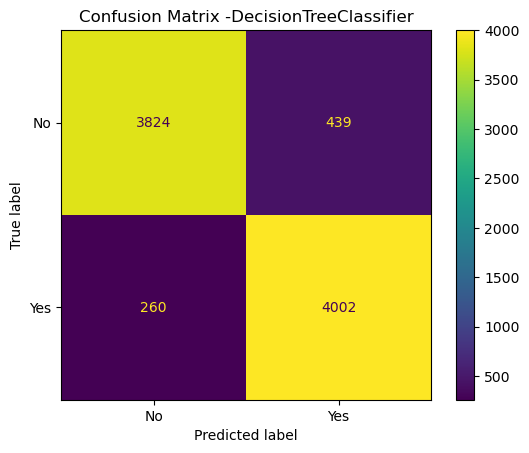

<Figure size 800x600 with 0 Axes>

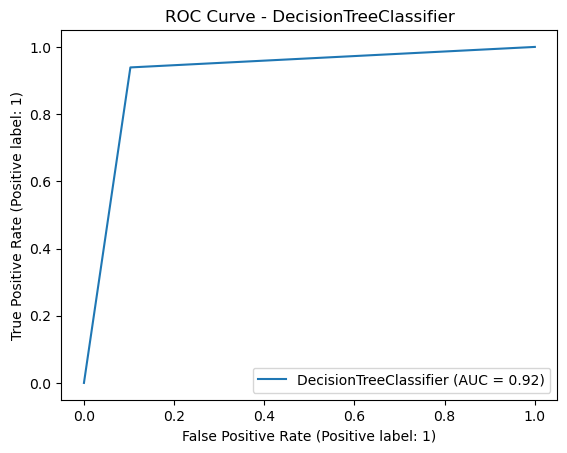

<Figure size 800x600 with 0 Axes>

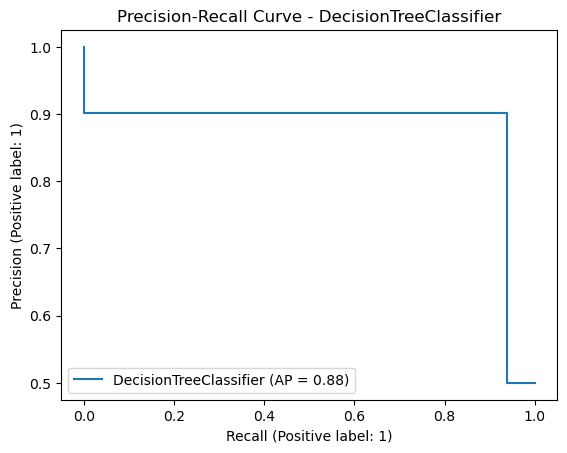

* RandomForestClassifier


<Figure size 800x600 with 0 Axes>

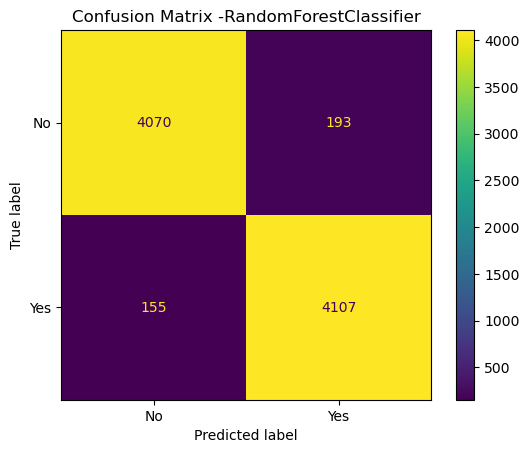

<Figure size 800x600 with 0 Axes>

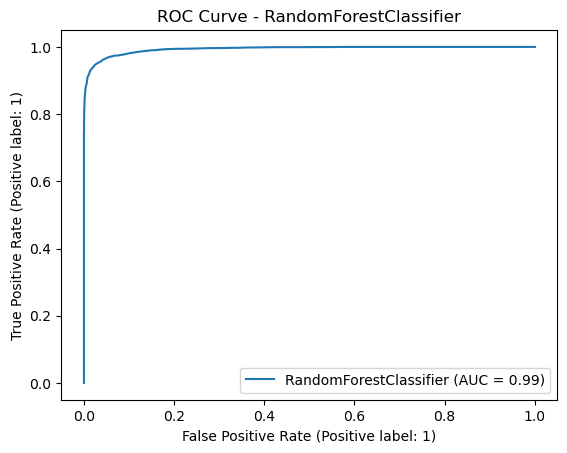

<Figure size 800x600 with 0 Axes>

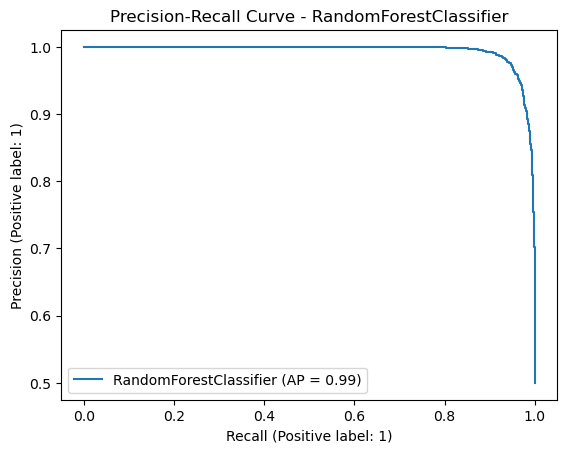

* AdaBoostClassifier


<Figure size 800x600 with 0 Axes>

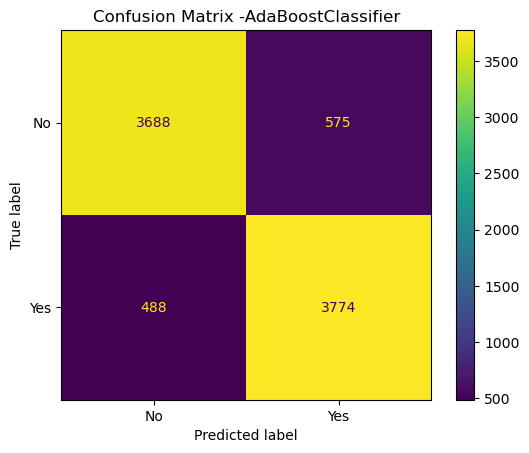

<Figure size 800x600 with 0 Axes>

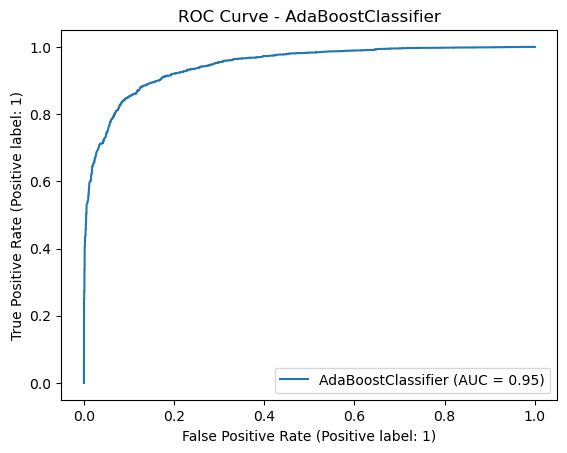

<Figure size 800x600 with 0 Axes>

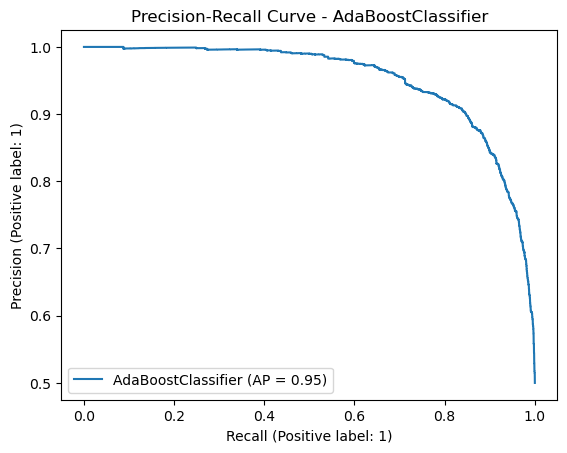

* MLPClassifier


<Figure size 800x600 with 0 Axes>

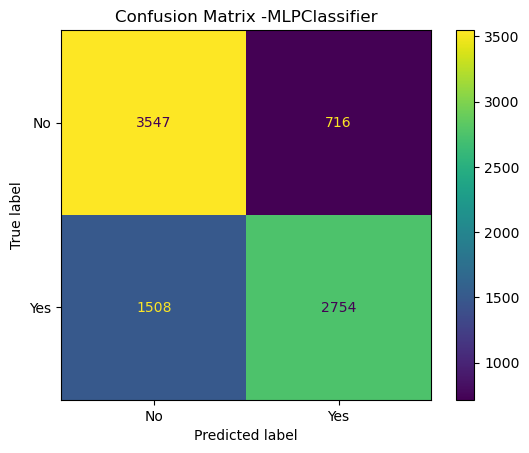

<Figure size 800x600 with 0 Axes>

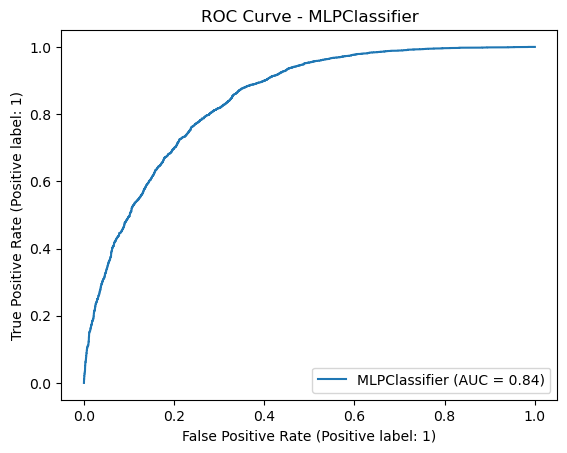

<Figure size 800x600 with 0 Axes>

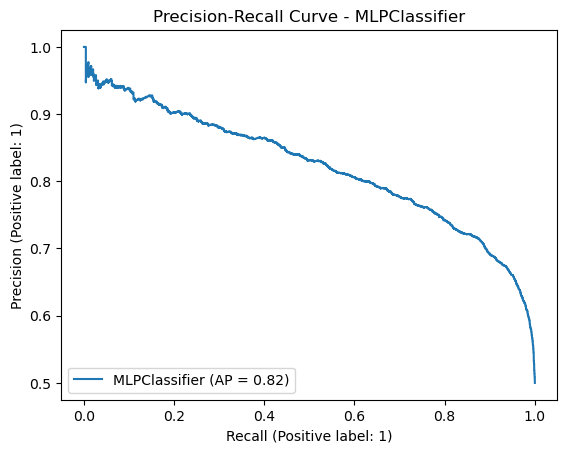

* KNeighborsClassifier


<Figure size 800x600 with 0 Axes>

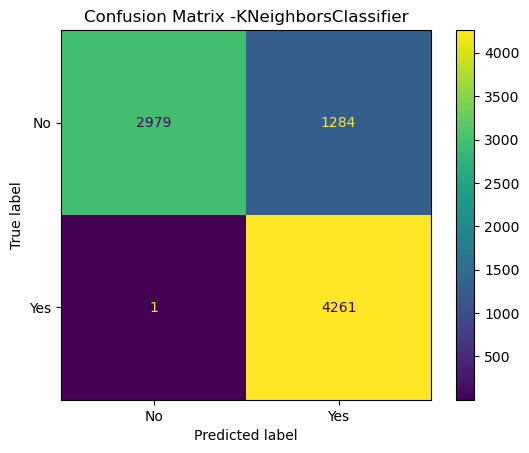

<Figure size 800x600 with 0 Axes>

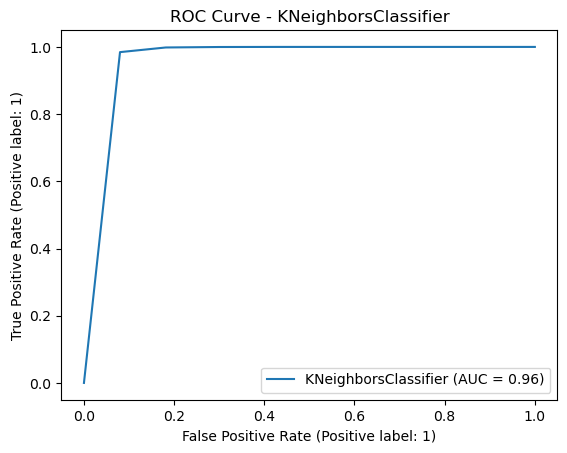

<Figure size 800x600 with 0 Axes>

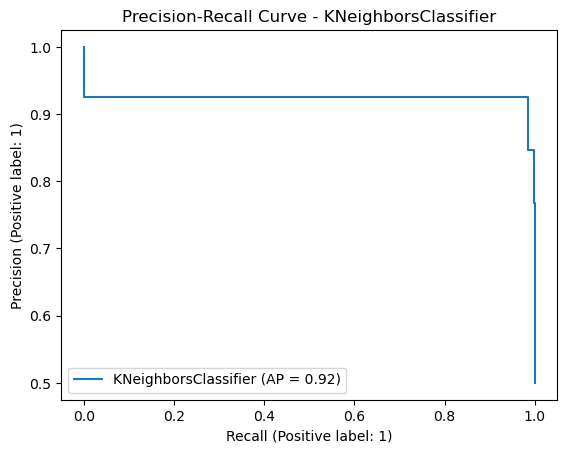

* LogisticRegression


<Figure size 800x600 with 0 Axes>

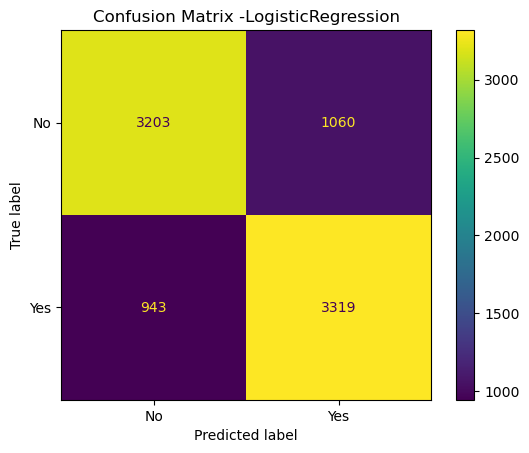

<Figure size 800x600 with 0 Axes>

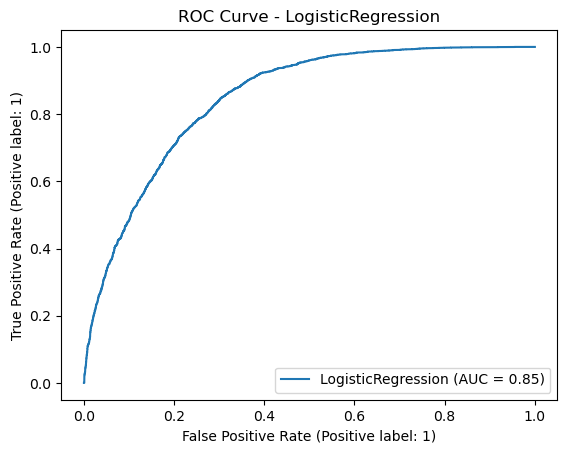

<Figure size 800x600 with 0 Axes>

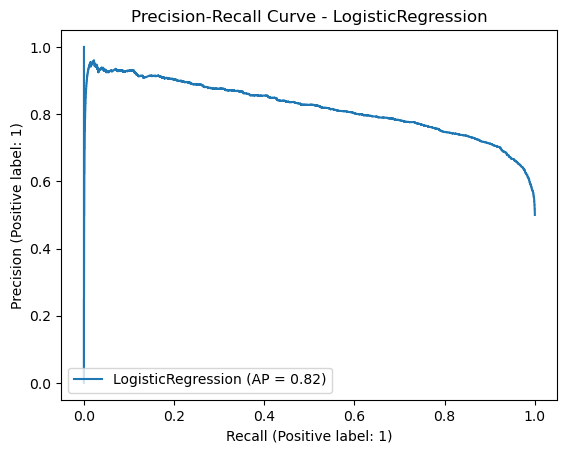

In [38]:
scorer = {'accuracy_score':metrics.make_scorer(metrics.accuracy_score),
          'f1_score':metrics.make_scorer(metrics.f1_score),
          'recall_score':metrics.make_scorer(metrics.recall_score),
          'precision_score':metrics.make_scorer(metrics.average_precision_score),
          'matthew_corrcoef':metrics.make_scorer(metrics.matthews_corrcoef),
          'roc_auc_score':metrics.make_scorer(metrics.roc_auc_score) }
for key in classifiers:
    print('*', key)
    start_time = time.time()
    classifier = classifiers[key]
    model = classifier.fit(X_train,y_train)
    cvs = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    cv_scores = cross_validate(model, X_test, y_test, cv=cvs, scoring = scorer)
    y_pred = model.predict(X_test)
    row = {
        'model': key,
        'run_time': format(round((time.time() - start_time)/60,2)),
        'avg_accy': cv_scores['test_accuracy_score'].mean(),
        'avg_accy_std': cv_scores['test_accuracy_score'].std(),
        'avg_recall': cv_scores['test_recall_score'].mean(),
        'avg_recall_std': cv_scores['test_recall_score'].std(),
        'avg_precision': cv_scores['test_precision_score'].mean(),
        'avg_precision_std': cv_scores['test_precision_score'].std(),
        'avg_f1': cv_scores['test_f1_score'].mean(),
        'avg_f1_std': cv_scores['test_f1_score'].std(),
        'avg_matthew_corcoef': cv_scores['test_matthew_corrcoef'].mean(),
        'avg_matthew_corcoef_std': cv_scores['test_matthew_corrcoef'].std(),
        'avg_roc_auc': cv_scores['test_roc_auc_score'].mean(),
        'avg_roc_auc_std': cv_scores['test_roc_auc_score'].std(),
    }
    models = models.append(row, ignore_index=True)
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(model, X_test, y_test, display_labels=["No", "Yes"])
    plt.title("Confusion Matrix -"+str(key))
    plt.show()

    # Visualize ROC Curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(model, X_test, y_test)
    plt.title("ROC Curve - "+str(key))
    plt.show()

    # Visualize Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plot_precision_recall_curve(model, X_test, y_test)
    plt.title("Precision-Recall Curve - "+str(key))
    plt.show()

    with open(f'models/'+str(key)+'.pkl', 'wb') as file:
            pickle.dump(model, file)


In [39]:
models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   model                    6 non-null      object 
 1   run_time                 6 non-null      object 
 2   avg_accy                 6 non-null      float64
 3   avg_accy_std             6 non-null      float64
 4   avg_recall               6 non-null      float64
 5   avg_recall_std           6 non-null      float64
 6   avg_precision            6 non-null      float64
 7   avg_precision_std        6 non-null      float64
 8   avg_f1                   6 non-null      float64
 9   avg_f1_std               6 non-null      float64
 10  avg_matthew_corcoef      6 non-null      float64
 11  avg_matthew_corcoef_std  6 non-null      float64
 12  avg_roc_auc              6 non-null      float64
 13  avg_roc_auc_std          6 non-null      float64
dtypes: float64(12), object(2)
memo

In [40]:
models

,model,run_time,avg_accy,avg_accy_std,avg_recall,avg_recall_std,avg_precision,avg_precision_std,avg_f1,avg_f1_std,avg_matthew_corcoef,avg_matthew_corcoef_std,avg_roc_auc,avg_roc_auc_std
0,DecisionTreeClassifier,0.07,0.871280,0.013659,0.898796,0.014033,0.816565,0.017641,0.874747,0.012937,0.743845,0.027074,0.871286,0.013657
1,RandomForestClassifier,0.72,0.932981,0.008954,0.949789,0.011243,0.897977,0.012492,0.934084,0.008776,0.866552,0.017866,0.932983,0.008957
2,AdaBoostClassifier,0.96,0.870264,0.010583,0.886674,0.015758,0.818061,0.013577,0.872344,0.010253,0.741184,0.021246,0.870265,0.010587
3,MLPClassifier,1.28,0.712581,0.056739,0.654457,0.212088,0.660607,0.042660,0.671745,0.154592,0.445786,0.103796,0.712612,0.056652
4,KNeighborsClassifier,0.12,0.798552,0.013917,0.989598,0.005130,0.714020,0.013952,0.830953,0.009719,0.646241,0.022569,0.798574,0.013919
5,LogisticRegression,0.92,0.763362,0.015865,0.785234,0.024761,0.698317,0.015446,0.768289,0.016894,0.527479,0.031913,0.763366,0.015866


In [1]:
from tabulate import tabulate
model_rf = RandomForestClassifier()

param_grid_rf = [{'n_estimators': [50, 100, 150],
                    'max_depth': [None, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                      'max_features': ['sqrt']}]

grid_search_rf = GridSearchCV(model_rf, param_grid=param_grid_rf, cv=10)
grid_search_rf = grid_search_rf.fit(X, y)
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_
results = grid_search_rf.cv_results_
param_combinations = results['params']
mean_test_scores = results['mean_test_score']

# Prepare data for tabulation
table_data = []
for params, mean_score in zip(param_combinations, mean_test_scores):
    row = [mean_score]
    row.extend(params.values())
    table_data.append(row)

# Define table headers
headers = ['Mean Score', 'max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'n_estimators']

# Generate and print the table
table = tabulate(table_data, headers=headers)
print(table)


NameError: name 'RandomForestClassifier' is not defined

In [ ]:
best_rf_params

In [ ]:
best_rf_model

In [ ]:

# Train the Random Forest Classifier model with the best parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predict using the best model
rf_pred = best_rf_model.predict(X_test)

# Calculate evaluation metrics
rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred, average='weighted')
rf_rec = recall_score(y_test, rf_pred, average='weighted')
rf_f1 = f1_score(y_test, rf_pred, average='weighted')
rf_cm = confusion_matrix(y_test, rf_pred)

# Print evaluation metrics
print("\nRandom Forest Classifier Accuracy:", rf_acc)
print("Random Forest Classifier Precision:", rf_prec)
print("Random Forest Classifier Recall:", rf_rec)
print("Random Forest Classifier F1 Score:", rf_f1)
print("Random Forest Classifier Confusion Matrix:\n", rf_cm)